## Grid.
The target of this nb is to get an 9x9 np array of the sudoku grid.

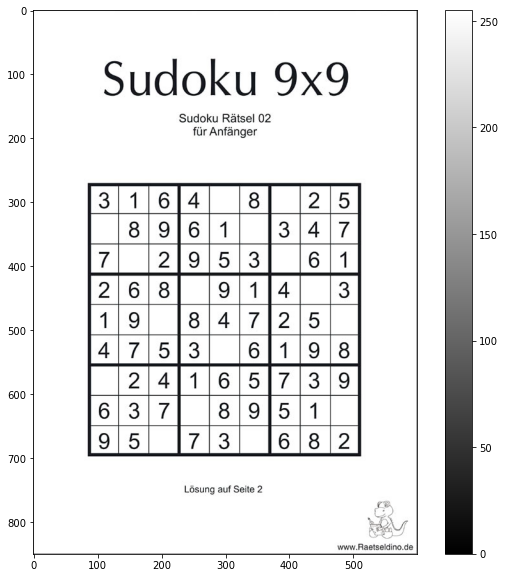

In [24]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

file_name = "sudoku-02-fuer-anfaenger.jpg"
#file_name = "Sudoku-Raetsel-schwer-1.jpg"
img = cv.imread(file_name)
#img = img.astype(np.float32)   #ensure floating point numbers
orig = np.copy(img)

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

#if len(img.shape) == 3: #3 dimensions: probably color channel in image
#    print("Reducing color image to grayscale")
#    img = np.sum(img, axis=2) #compress one image axis

def show(image, size_y = 10, size_x = 10):
    #cv2.imshow(img)
    plt.figure(figsize = (size_y,size_x))
    plt.imshow(image, cmap='gray')
    plt.colorbar()
show(img)


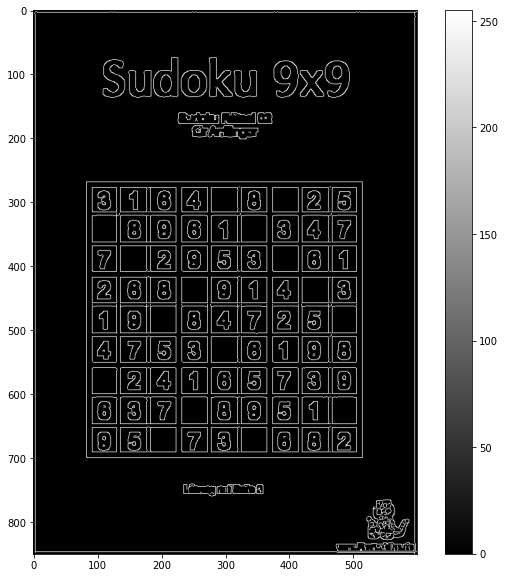

In [25]:
kernel = np.ones((5,5),np.uint8)
erode = cv.erode(gray,kernel,iterations = 1)
edges = cv.Canny(erode,80,170,apertureSize = 3)
show(edges)

I've found 44 lines
combine_lines: 4 lines removed due too removeBorders operation
combine_lines: 20 lines removed due too combineClose operation
combine_lines: Found len(hlines)=10 and len(vlines)=10 in combineClose operation
Now there are 20 Lines


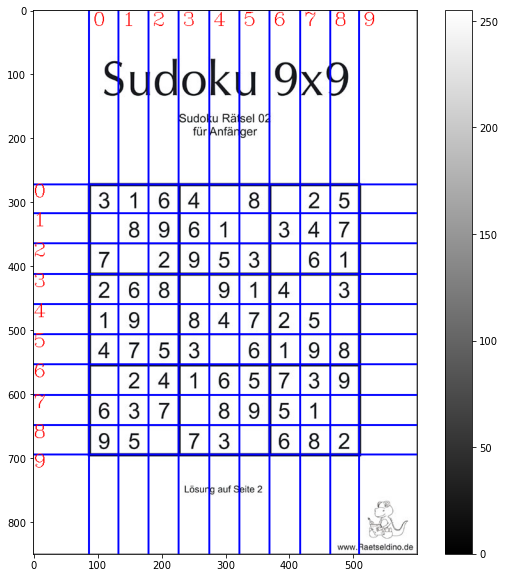

In [26]:
lines = cv.HoughLines(edges,1,np.pi/180, threshold=250)
def transform_lines(lines):
    '''
    Transforms lines into the cartesian coordinate room
    '''
    output = []
    if not lines.any():
        return output
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        output.append([(y1, x1), (y2, x2)])
        #print(f"{x0=},{y0=} {x1=},{y1=}")
    return output

def combine_lines(lines, image_shape, isHoughRoom=False, removeBorders=True, threshold = 30):
    '''
    Combine nearby lines

    image_shape: (h, w), shape of the image
    isHoughRoom: Are the lines in the hough coordinate room format?
    removeBorders: Remove borders?

    returns: horizontal lines (y coordinates only), vertical lines (x coordinates only)
    '''
    h, w = image_shape
    if isHoughRoom:
        lines = transform_lines(lines)
    if removeBorders:
        output = []
        for line in lines:
            (y0, x0), (y1, x1) = line
            left = x0 < threshold and x1 < threshold
            right = x0 > w-threshold and x1 > w-threshold
            top = y0 < threshold and y1 < threshold
            bottom = y0 > (h-threshold) and y1 > (h-threshold)
            #print(line)
            #print(f"{x0=},{y0=} {x1=},{y1=}")
            #print(f"{top=} {bottom=} {left=} {right=}")
            #print(10*"-")
            if not (top or bottom or left or right):
                output.append(line)
        print(f"combine_lines: {len(lines)-len(output)} lines removed due too removeBorders operation")
        lines = output

    # Combine close
    hlines = []
    vlines = []
    processed_iis = []
    for ii, line in enumerate(lines):
        if ii in processed_iis:
            continue
        processed_iis.append(ii)
        (y0, x0), (y1, x1) = line

        found_pair = False
        for jj, other_line in enumerate(lines):
            if ii == jj or jj in processed_iis:
                continue
            (ny0, nx0), (ny1, nx1) = other_line

            # Horizontal Line
            if abs(x1-x0) > abs(y1-y0) and abs(nx1-nx0) > abs(ny1-ny0):
                #print(f"{abs(x1-x0)=} > {abs(y1-y0)=} and {abs(nx1-nx0)=} > {abs(ny1-ny0)=}:")
                #print(f"{abs(y0-ny0)=} < {threshold} and {abs(y1-ny1)=} < {threshold}")

                if abs(y0-ny0) < threshold and abs(y1-ny1) < threshold:
                    #my0 = my1 = int((y0 + y1 + ny0 + ny1)/4)
                    #mx0 = -w
                    #mx1 = w
                    #hlines.append([(my0, mx0), (my1, mx1)])
                    hlines.append(int((y0 + y1 + ny0 + ny1)/4))
                    processed_iis.append(jj)
                    found_pair = True
                    break

            # Vertical Line
            if abs(y1-y0) > abs(x1-x0) and abs(ny1-ny0) > abs(nx1-nx0):
                 if abs(x0-nx0) < threshold and abs(x1-nx1) < threshold:
                    #mx0 = mx1 = int((x0 + x1 + nx0 + nx1)/4)
                    #my0 = -h
                    #my1 = h
                    #vlines.append([(my0, mx0), (my1, mx1)])
                    vlines.append(int((x0 + x1 + nx0 + nx1)/4))
                    found_pair = True
                    processed_iis.append(jj)
                    break

        if not found_pair:
            if abs(y1-y0) > abs(x1-x0) and abs(ny1-ny0) > abs(nx1-nx0):
                vlines.append(int((x0 + x1)/2))
            elif abs(x1-x0) > abs(y1-y0) and abs(nx1-nx0) > abs(ny1-ny0):
                hlines.append(int((y0 + y1)/2))

    # Sort lines
    vlines.sort()
    hlines.sort()        

    print(f"combine_lines: {len(lines)-len(hlines)-len(vlines)} lines removed due too combineClose operation")
    print(f"combine_lines: Found {len(hlines)=} and {len(vlines)=} in combineClose operation")

    return hlines, vlines


print(f"I've found {len(lines)} lines")
lines = transform_lines(lines)
h, w, _ = orig.shape

hlines, vlines = combine_lines(lines, (h, w))
print(f"Now there are {len(hlines)+len(vlines)} Lines")

img = np.copy(orig)

for ii, y in enumerate(hlines):
    cv.line(img,(0, y),(w,y),(0,0,255),2)
    cv.putText(img, text=str(ii), org=(0, y+20), fontFace=cv.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255, 0, 0))

for ii, x in enumerate(vlines):
    cv.line(img,(x, 0),(x,h),(0,0,255),2)
    cv.putText(img, text=str(ii), org=(x+6, 24), fontFace=cv.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255,0 , 0))
show(img)

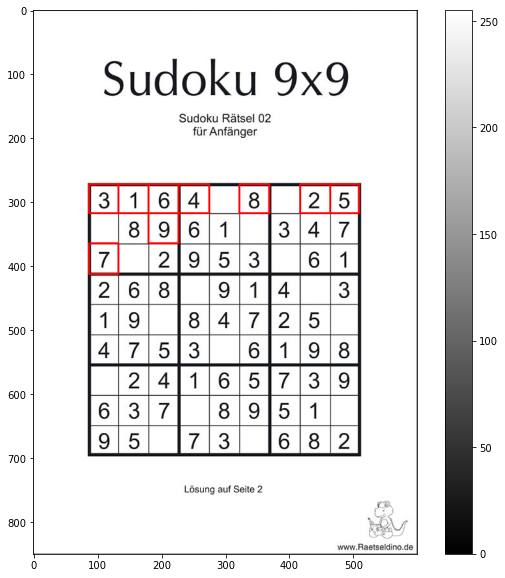

In [27]:
# Save Coordinate Pictures
img = np.copy(orig)

def coordinates_to_cell(img, hlines, vlines, coordinates):
    '''
    Converts 11-99 Coordinates to Cell

    coordinates = (v, h)
    returns (x0, y0), (x1, y1) coordinates for that specific cell
    '''
    if len(hlines) != 10 or len(vlines) != 10:
        raise Exception("False length of hlines or vlines")

    v, h = coordinates
    x0 = vlines[v-1]
    x1 = vlines[v-0]
    
    y0 = hlines[h-1]
    y1 = hlines[h-0]
    return (x0, y0), (x1, y1)

def save_pattern(img, coordinates, hlines, vlines, digit, scale = 0.9):
    '''
    Converts 11-99 Coordinates to Cell

    :param: coordinates = (v, h)
    :param: hlines: horizontal lines
    :param: vlines: vertical lines
    :param: digit: The digit in the cell
    :scale: scale
    returns None
    '''
    (x0, y0), (x1, y1) = coordinates_to_cell(img, hlines, vlines, coordinates)

    w_tran = int((x1-x0) * (1-scale))
    h_tran = int((y1-y0)* (1-scale))
    tx0 = (x0+w_tran)
    tx1 = (x1-w_tran)
    ty0 = (y0+h_tran)
    ty1 = (y1-h_tran)

    cropped = img[ty0:ty1, tx0:tx1]
    cv.imwrite(f'digits/{digit}.png', cropped)
    cv.rectangle(img, (x0, y0), (x1, y1), color = (255, 0, 0), 	thickness = 2)

if 0:
    save_pattern(img, (1,1), digit=3, hlines=hlines, vlines=vlines)
    save_pattern(img, (2,1), digit=1, hlines=hlines, vlines=vlines)
    save_pattern(img, (3,1), digit=6, hlines=hlines, vlines=vlines)
    save_pattern(img, (4,1), digit=4, hlines=hlines, vlines=vlines)
    save_pattern(img, (6,1), digit=8, hlines=hlines, vlines=vlines)
    save_pattern(img, (8,1), digit=2, hlines=hlines, vlines=vlines)
    save_pattern(img, (9,1), digit=5, hlines=hlines, vlines=vlines)
    save_pattern(img, (3,2), digit=9, hlines=hlines, vlines=vlines)
    save_pattern(img, (1,3), digit=7, hlines=hlines, vlines=vlines)

show(img)

In [28]:
pattern = np.zeros((9, 9), dtype=np.uint8)

print(pattern)

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
